# Linear vs Polynomial Regression

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

import random
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# set the seeds for reproducibility
random.seed(412)
np.random.seed(412)

### Generate Data for Regression

In [3]:
def mapping(x, slope, bias):
  y = slope * x + bias  # linear function
  return y


def generate_data(f, N, x_min, x_max):
  x_standard = np.random.rand(N, 1) # x values uniformly sampled from range [0, 1]
  x = x_standard * (x_max - x_min) + x_min   # carrying x values to the desired range [x_min, x_max]
  y = f(x) # compute y values from the underlying function f
  eps = 0.1 * np.random.randn(*y.shape)   # Gaussian noise with 0.1 standard deviation
  return x, y + eps   # return x's and corrupted f(x) values

### Parameters for the Data Generation

In [ ]:
slope, bias = 2.5, 0.5    # slope (w1) and bias (w0) of the linear component
x_min, x_max = 0.0, 1.0   # range of x values
N = 50                   # number of samples

# set the slope, bias parameters of the mapping() function; leave x
f = lambda x : mapping(x, slope=slope, bias=bias)

# generate N samples with function f, where the x is in range [x_min, x_max]
x, y = generate_data(f, N, x_min, x_max)
print('x.shape :', x.shape, ', y.shape :', y.shape)

x.shape : (50, 1) , y.shape : (50, 1)


### 50% Train 50% Validation Split

In [5]:
# Partition the dataset into train and test datasets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, shuffle=False)

### Making a scatter plot of the data

In [6]:
def plot_samples(train_data, val_data=None):
  fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

  x_train, y_train = train_data
  ax.scatter(x_train, y_train, label='train samples')
  if val_data:
    x_val, y_val = val_data
    ax.scatter(x_val, y_val, label='val samples')

  ax.set_xlim([-0.05, 1.05])  # need to change
  ax.set_ylim([-0.05, 3.55])  # need to change
  ax.set_xlabel('x', fontsize=12)
  ax.set_ylabel('f(x)', fontsize=12)
  ax.set_title('Simulated Nonlinear Data')
  ax.legend(loc='lower right')
  return fig, ax

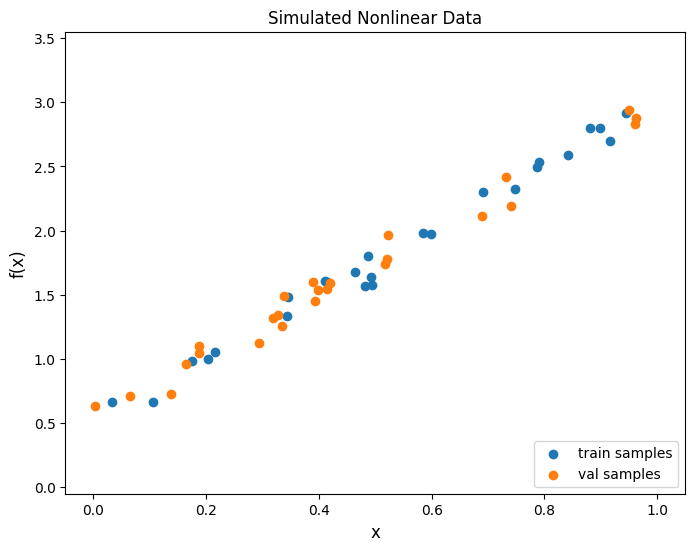

In [7]:
# Plot train and test datasets
fig, ax = plot_samples(train_data=(x_train, y_train), val_data=(x_val, y_val))

### Function for plotting the MSE loss

In [8]:
def plot_mse_loss(mse_values):
  plt.figure(figsize=(10, 6))
  plt.plot(mse_values, label='MSE per Iteration')
  plt.xlabel('Iteration')
  plt.ylabel('Mean Squared Error')
  plt.title('MSE During Training')
  plt.legend()
  plt.show()

In [9]:
del x, y, x_train, y_train, x_val, y_val # I am deleting the variables so that you can start from scratch

### Generate Dataset 1



In [10]:
def mapping(x, slope, bias):
    """Linear function used to generate y values."""
    return slope * x + bias

def generate_data(f, N, x_min, x_max):
    """
    Generates (x, y) data where x is sampled uniformly in [x_min, x_max]
    and y = f(x) + Gaussian noise with std dev = 0.1.
    """
    x_standard = np.random.rand(N, 1)  # uniformly in [0, 1]
    x = x_standard * (x_max - x_min) + x_min
    y = f(x)
    eps = 0.1 * np.random.randn(*y.shape)  # Gaussian noise
    return x, y + eps

# ----- Parameters for Dataset 1 -----
slope, bias = 2.5, 0.5
x_min, x_max = 0.0, 1.0
N = 50  # number of samples

# Define the underlying function f
f = lambda x: mapping(x, slope, bias)

# Generate the data
x, y = generate_data(f, N, x_min, x_max)
print("Generated x shape:", x.shape, "Generated y shape:", y.shape)

# Split the data 50%-50% into train and validation (no shuffle)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, shuffle=False)

# Print shapes to verify
print("Training data shapes:", x_train.shape, y_train.shape)
print("Validation data shapes:", x_val.shape, y_val.shape)


Generated x shape: (50, 1) Generated y shape: (50, 1)
Training data shapes: (25, 1) (25, 1)
Validation data shapes: (25, 1) (25, 1)


# 1) Linear Regression on Dataset 1

## 1.a) Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(x_train, y_train)

# Predict on the validation set
y_pred = model.predict(x_val)

# Evaluate the performance using mean squared error (MSE)
mse_sklearn = mean_squared_error(y_val, y_pred)

# Print the model's mean squared error
print('MSE of sklearn model: ', mse_sklearn)


MSE of sklearn model:  0.00795462682779033


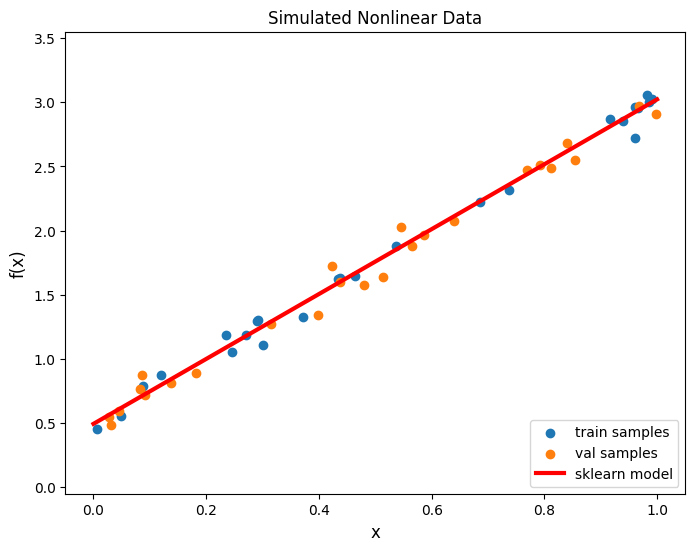

In [16]:
# Make a scatter plot of the train and validation samples
fig, ax = plot_samples((x_train, y_train), (x_val, y_val))

x_grid = np.linspace(x_min, x_max, 100)  # do not change anything in this line

# Use the model's predict() function on x_grid (reshaping x_grid as needed)
y_grid = model.predict(x_grid.reshape(-1, 1))

# Draw the regression line on the scatter plot
ax.plot(x_grid, y_grid, color='red', linewidth=3, label='sklearn model')
ax.legend(loc='lower right')


## 1.b) Manual Ordinary Least Squares (Pseudo-inverse)

In [13]:
from numpy.linalg import pinv
from sklearn.metrics import mean_squared_error

# 1. Construct the extended data matrix for train by adding a column of ones for the intercept
X_train_extended = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
# 2. Construct the extended data matrix for validation similarly
X_val_extended = np.concatenate((np.ones((x_val.shape[0], 1)), x_val), axis=1)

# Print the shapes of the extended data matrices to check
print("Extended X_train shape:", X_train_extended.shape)
print("Extended X_val shape:", X_val_extended.shape)

# 3.1. Compute the pseudoinverse of the extended training data matrix
X_train_pinv = pinv(X_train_extended)

# 3.2. Calculate regression coefficients (w) using the pseudoinverse (w has dimensions 2 x 1)
w = np.matmul(X_train_pinv, y_train)

# Find the model's predictions on the validation set using the extended validation matrix
y_val_pred_manual = np.matmul(X_val_extended, w)

# Evaluate the model's performance on the validation set using mean squared error (MSE)
mse_manual = mean_squared_error(y_val, y_val_pred_manual)

# Print the model's mean squared error
print('MSE of manual model: ', mse_manual)


Extended X_train shape: (25, 2)
Extended X_val shape: (25, 2)
MSE of manual model:  0.007954626827790374


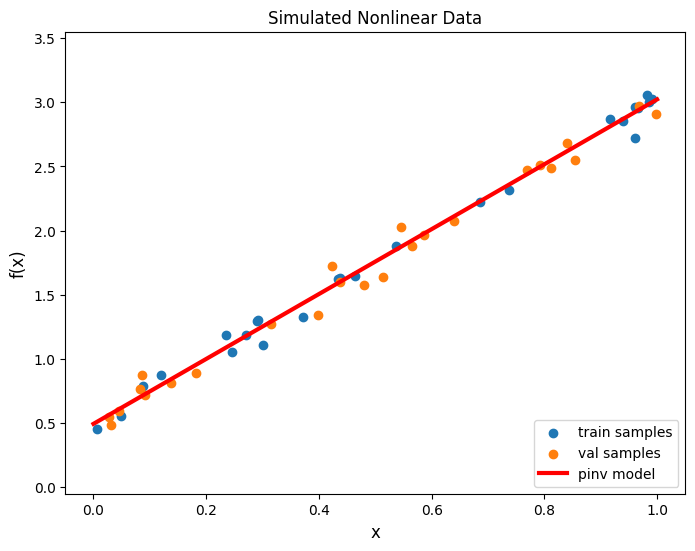

In [15]:
# Make a scatter plot of the train and validation samples using plot_samples()
fig, ax = plot_samples((x_train, y_train), (x_val, y_val))

x_grid = np.linspace(x_min, x_max, 100)[..., np.newaxis]  # do not change anything in this line

# First, construct the extended version of x_grid (adding a column of ones)
X_grid_extended = np.concatenate((np.ones((x_grid.shape[0], 1)), x_grid), axis=1)

# Now, using the regression coefficients (w) from the pinv solution, find the model's predictions
y_grid = np.matmul(X_grid_extended, w)

# Plot the regression line using the computed y_grid
ax.plot(x_grid, y_grid, color='red', linewidth=3, label='pinv model')
ax.legend(loc='lower right')


## 1.c) Manual Gradient Descent 

In [ ]:
M = 1000  # number of iterations
lr = 0.1  # learning rate
mse_values = []  # list to keep track of the MSE at each iteration

# Ensure y_train is a column vector (N x 1)
if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)

# Initialize regression coefficients (w) as a 2x1 vector (for bias and slope)
w_gd = np.zeros((X_train_extended.shape[1], 1))  # shape: (2, 1)
N_train = X_train_extended.shape[0]  # number of training samples

for i in range(M):
    # 1. Compute predicted values: y_pred = X_train_extended * w_gd
    y_pred = np.matmul(X_train_extended, w_gd)

    # 2. Compute the error: pred_error = y_pred - y_train
    error = y_pred - y_train

    # 3. Compute the gradient: w_grad = (transpose(X_train_extended) * error) / N_train
    w_grad = np.matmul(X_train_extended.T, error) / N_train

    # 4. Update the regression coefficients: w_gd = w_gd - lr * w_grad
    w_gd = w_gd - lr * w_grad

    # 5. Calculate the current MSE = (1/(2*N_train)) * sum((error)^2)
    mse_val = (1 / (2 * N_train)) * np.sum(error**2)

    # 6. Append the loss to the mse_values list
    mse_values.append(mse_val)

    if i == 0 or ((i + 1) % 100 == 0):
        print('MSE error at step {}: {:.4f}'.format(i + 1, mse_val))


MSE error at step 1: 2.0573
MSE error at step 100: 0.0313
MSE error at step 200: 0.0075
MSE error at step 300: 0.0035
MSE error at step 400: 0.0028
MSE error at step 500: 0.0027
MSE error at step 600: 0.0026
MSE error at step 700: 0.0026
MSE error at step 800: 0.0026
MSE error at step 900: 0.0026
MSE error at step 1000: 0.0026


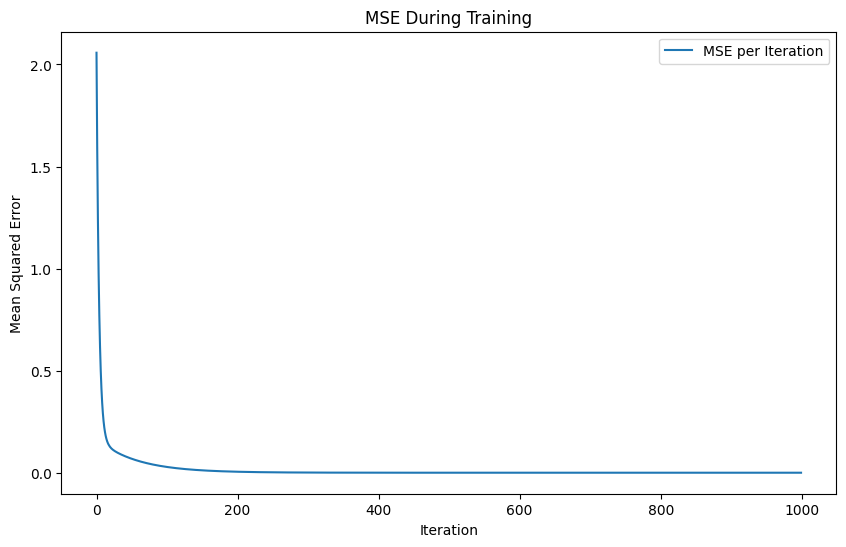

In [18]:
# ----- Plot the MSE Loss -----
plot_mse_loss(mse_values)


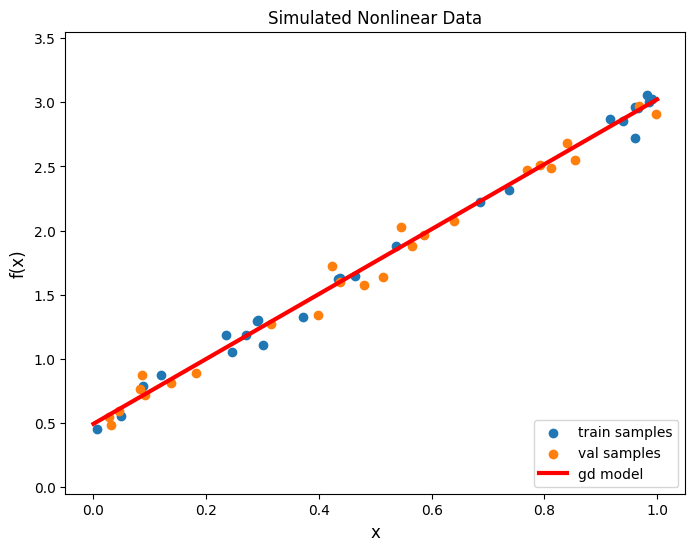

In [19]:
# Make a scatter plot of the train and validation samples using plot_samples()
fig, ax = plot_samples((x_train, y_train), (x_val, y_val))

x_grid = np.linspace(x_min, x_max, 100)[..., np.newaxis]  # do not change anything in this line

# Construct the extended version of x_grid by adding a column of ones (for the intercept)
X_grid_extended = np.concatenate((np.ones((x_grid.shape[0], 1)), x_grid), axis=1)

# Compute predictions on x_grid using the regression coefficients from gradient descent
y_grid = np.matmul(X_grid_extended, w_gd)

# Draw the regression line on the scatter plot
ax.plot(x_grid, y_grid, color='red', linewidth=3, label='gd model')
ax.legend(loc='lower right')


# 2) Polynomial Regression on Dataset 2 

### Data Loading for a Nonlinear Dataset

In [22]:
from google.colab import files
uploaded = files.upload()

Saving dataset2_data.npy to dataset2_data.npy
Saving dataset2_labels.npy to dataset2_labels.npy


In [23]:
# Load Dataset 2 from .npy files
x = np.load('dataset2_data.npy')
y = np.load('dataset2_labels.npy')

# Optional: print the shapes of the loaded data
print("x shape:", x.shape)
print("y shape:", y.shape)

# Split the data into train and validation sets (50%-50%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, shuffle=False)

# Print the shapes of the split datasets to verify the partition
print("Train set shapes: x_train:", x_train.shape, ", y_train:", y_train.shape)
print("Validation set shapes: x_val:", x_val.shape, ", y_val:", y_val.shape)


x shape: (50, 1)
y shape: (50, 1)
Train set shapes: x_train: (25, 1) , y_train: (25, 1)
Validation set shapes: x_val: (25, 1) , y_val: (25, 1)


## 2.a) Linear Regression on Polynomial Features

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Try polynomial degrees of 1, 3, 5, and 7
for order in [1, 3, 5, 7]:
    # order = ... # <-- specify the order of the polynomial features
    poly = PolynomialFeatures(degree=order)  # construct polynomial features of degree "order"

    # fit the polynomial features to training data using fit_transform()
    X_train_poly = poly.fit_transform(x_train)
    # transform the validation data using transform()
    X_val_poly = poly.transform(x_val)

    # initialize linear regression model
    model_poly = LinearRegression()
    # fit the model to the polynomial features of training data
    model_poly.fit(X_train_poly, y_train)
    # make predictions on validation set
    y_pred_poly = model_poly.predict(X_val_poly)

    # evaluate the model's performance on the validation set using mean squared error (MSE)
    mse_sklearn_polynomial = mean_squared_error(y_val, y_pred_poly)

    # print the model's mean squared error
    print('Degree {}: MSE of sklearn model: {}'.format(order, mse_sklearn_polynomial))


Degree 1: MSE of sklearn model: 0.06362852709262727
Degree 3: MSE of sklearn model: 0.012059223742868292
Degree 5: MSE of sklearn model: 0.007475463079281102
Degree 7: MSE of sklearn model: 0.011549227838827407


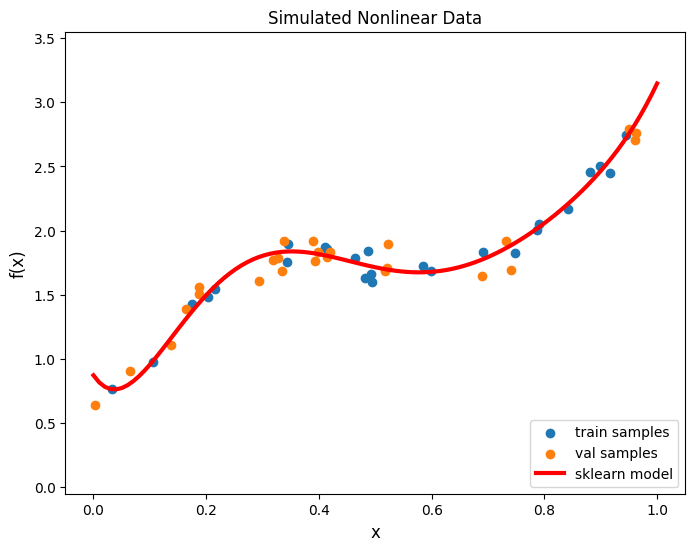

In [25]:
# Make a scatter plot of the train and validation samples using plot_samples()
fig, ax = plot_samples((x_train, y_train), (x_val, y_val))

x_grid = np.linspace(x_min, x_max, 100)[..., np.newaxis]  # do not change anything in this line

# Transform x_grid the same way you transformed the validation data
X_grid_poly = poly.transform(x_grid)

# Now use the linear regression model's predict() function on the transformed x_grid to find y_grid
y_grid = model_poly.predict(X_grid_poly)

# Plot the regression curve on the scatter plot
ax.plot(x_grid, y_grid, color='red', linewidth=3, label='sklearn model')
ax.legend(loc='lower right')

## 2.b) Manual Polynomial Regression via Pseudoinverse

In [26]:
from numpy.linalg import pinv
from sklearn.metrics import mean_squared_error

# 1. Construct the data matrix for training by adding columns for x^0, x^1, x^2, and x^3.
X_train_poly3 = np.concatenate((np.ones((x_train.shape[0], 1)),
                                x_train,
                                x_train**2,
                                x_train**3), axis=1)
# 2. Construct the data matrix for validation similarly.
X_val_poly3 = np.concatenate((np.ones((x_val.shape[0], 1)),
                              x_val,
                              x_val**2,
                              x_val**3), axis=1)

# Print the shapes to check the extended data matrices
print("X_train_poly3 shape:", X_train_poly3.shape)
print("X_val_poly3 shape:", X_val_poly3.shape)

# 3.1. Find the pseudoinverse of the training data matrix.
X_train_pinv_poly3 = pinv(X_train_poly3)
# 3.2. Compute the regression coefficients: w = pinv(X) * y.
w_poly3 = np.matmul(X_train_pinv_poly3, y_train)

# Find the model's predictions on the validation set.
y_val_pred_poly3_manual = np.matmul(X_val_poly3, w_poly3)

# Evaluate the model's performance using mean squared error (MSE).
mse_manual_poly3 = mean_squared_error(y_val, y_val_pred_poly3_manual)
print('MSE of manual polynomial regression model: ', mse_manual_poly3)


X_train_poly3 shape: (25, 4)
X_val_poly3 shape: (25, 4)
MSE of manual polynomial regression model:  0.01205922374286855


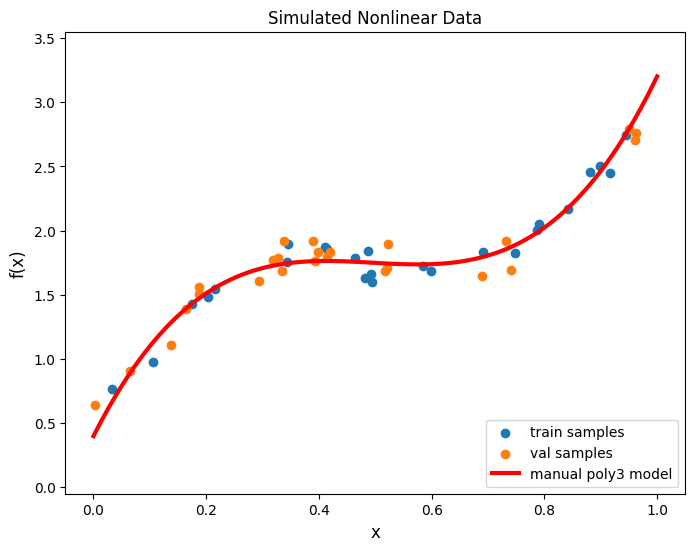

In [27]:
# Make a scatter plot of the train and validation samples using the provided plot_samples() function.
fig, ax = plot_samples((x_train, y_train), (x_val, y_val))

x_grid = np.linspace(x_min, x_max, 100)[..., np.newaxis]  # do not change anything in this line

# Transform x_grid the same way as the training and validation data:
X_grid_poly3 = np.concatenate((np.ones((x_grid.shape[0], 1)),
                               x_grid,
                               x_grid**2,
                               x_grid**3), axis=1)

# Now, using the regression coefficients, find the model's predictions (y_grid = X * w).
y_grid_poly3_manual = np.matmul(X_grid_poly3, w_poly3)

# Plot the regression curve on the scatter plot.
ax.plot(x_grid, y_grid_poly3_manual, color='red', linewidth=3, label='manual poly3 model')
ax.legend(loc='lower right')